# Sephora Beauty Recommendation Sytem 

### Dataset
 
The dataset used for this demo was collected from the Kaggle dataset titled ["Sephora Products and Skincare Reviews"](https://www.kaggle.com/datasets/nadyinky/sephora-products-and-skincare-reviews). It consists of  8,000 beauty products comprehensive information available on the Sephora website. Each product in the dataset is associated with various attributes, including the product name, brand name, price, ingredients, ratings, and other relevant features.



### Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder
from scipy.sparse import hstack
from surprise import Dataset, Reader, KNNBasic, SVD, NMF, accuracy, KNNWithZScore
from surprise.model_selection import train_test_split, cross_validate, GridSearchCV
from surprise.model_selection.validation import cross_validate
from surprise.accuracy import rmse, mae
from surprise.prediction_algorithms import Prediction
from sklearn.metrics import precision_score, recall_score, f1_score
from tabulate import tabulate


### Load Data

In [2]:
# Load the dataset
df_product_info = pd.read_csv("datasets/product_info.csv", header = 0)


### Product Data Stats

In [3]:
df_product_info.head()

,product_id,product_name,brand_id,brand_name,loves_count,rating,reviews,size,variation_type,variation_value,...,online_only,out_of_stock,sephora_exclusive,highlights,primary_category,secondary_category,tertiary_category,child_count,child_max_price,child_min_price
0,P473671,Fragrance Discovery Set,6342,19-69,6320,3.6364,11.0,NaN,NaN,NaN,...,1,0,0,"['Unisex/ Genderless Scent', 'Warm &Spicy Scen...",Fragrance,Value & Gift Sets,Perfume Gift Sets,0,NaN,NaN
1,P473668,La Habana Eau de Parfum,6342,19-69,3827,4.1538,13.0,3.4 oz/ 100 mL,Size + Concentration + Formulation,3.4 oz/ 100 mL,...,1,0,0,"['Unisex/ Genderless Scent', 'Layerable Scent'...",Fragrance,Women,Perfume,2,85.0,30.0
2,P473662,Rainbow Bar Eau de Parfum,6342,19-69,3253,4.2500,16.0,3.4 oz/ 100 mL,Size + Concentration + Formulation,3.4 oz/ 100 mL,...,1,0,0,"['Unisex/ Genderless Scent', 'Layerable Scent'...",Fragrance,Women,Perfume,2,75.0,30.0
3,P473660,Kasbah Eau de Parfum,6342,19-69,3018,4.4762,21.0,3.4 oz/ 100 mL,Size + Concentration + Formulation,3.4 oz/ 100 mL,...,1,0,0,"['Unisex/ Genderless Scent', 'Layerable Scent'...",Fragrance,Women,Perfume,2,75.0,30.0
4,P473658,Purple Haze Eau de Parfum,6342,19-69,2691,3.2308,13.0,3.4 oz/ 100 mL,Size + Concentration + Formulation,3.4 oz/ 100 mL,...,1,0,0,"['Unisex/ Genderless Scent', 'Layerable Scent'...",Fragrance,Women,Perfume,2,75.0,30.0


In [4]:
df_product_info.shape

(8494, 27)

In [5]:
df_product_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8494 entries, 0 to 8493
Data columns (total 27 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   product_id          8494 non-null   object 
 1   product_name        8494 non-null   object 
 2   brand_id            8494 non-null   int64  
 3   brand_name          8494 non-null   object 
 4   loves_count         8494 non-null   int64  
 5   rating              8216 non-null   float64
 6   reviews             8216 non-null   float64
 7   size                6863 non-null   object 
 8   variation_type      7050 non-null   object 
 9   variation_value     6896 non-null   object 
 10  variation_desc      1250 non-null   object 
 11  ingredients         7549 non-null   object 
 12  price_usd           8494 non-null   float64
 13  value_price_usd     451 non-null    float64
 14  sale_price_usd      270 non-null    float64
 15  limited_edition     8494 non-null   int64  
 16  new   

In [6]:
# check missing values
(df_product_info.isnull() | df_product_info.empty | df_product_info.isna()).sum()

product_id               0
product_name             0
brand_id                 0
brand_name               0
loves_count              0
rating                 278
reviews                278
size                  1631
variation_type        1444
variation_value       1598
variation_desc        7244
ingredients            945
price_usd                0
value_price_usd       8043
sale_price_usd        8224
limited_edition          0
new                      0
online_only              0
out_of_stock             0
sephora_exclusive        0
highlights            2207
primary_category         0
secondary_category       8
tertiary_category      990
child_count              0
child_max_price       5740
child_min_price       5740
dtype: int64

### Product Data Preprocessing

In [7]:
# use relevant columns 
df_product = df_product_info[['product_id', 'product_name', 'brand_name','ingredients','highlights', 'primary_category', 'secondary_category', 'tertiary_category']]

In [8]:
pd.options.mode.chained_assignment = None

#Fill in the values of secondary incase of missing values for teritary category and fill empty string for missing highlights
df_product['tertiary_category'] = df_product['tertiary_category'].fillna(df_product['secondary_category'])
df_product['highlights'] = df_product['highlights'].fillna('')

In [9]:
# check missing values
(df_product.isnull() | df_product.empty | df_product.isna()).sum()

product_id              0
product_name            0
brand_name              0
ingredients           945
highlights              0
primary_category        0
secondary_category      8
tertiary_category       8
dtype: int64

In [10]:
# check duplicated
df_product.duplicated().sum()

0

In [11]:
#drop missing values data
df_product = df_product.dropna()

In [12]:
df_product = df_product.reset_index(drop=True)

## Exploratory Data Analysis

### Product Data

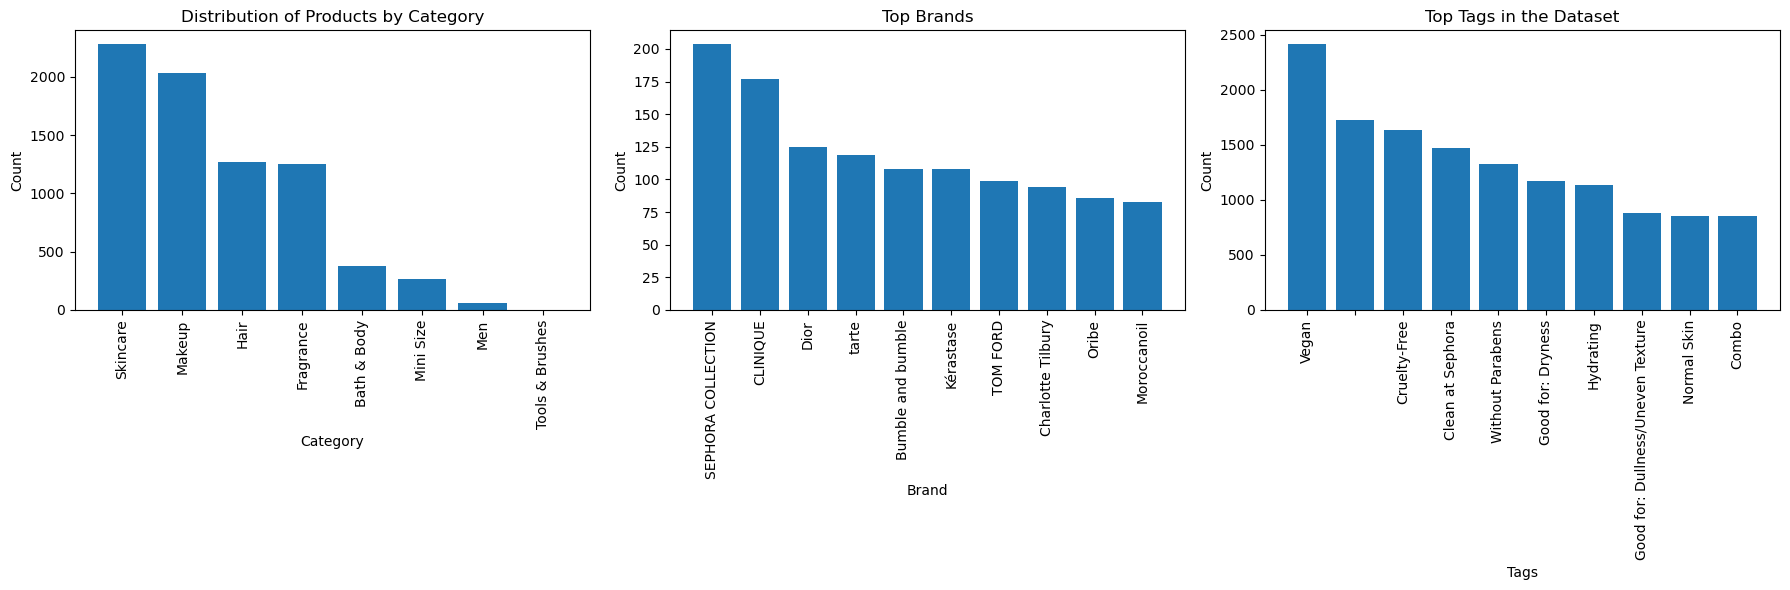

In [13]:

# Create subplots with 1 row and 3 columns
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Primary Category Analysis
primary_category_counts = df_product['primary_category'].value_counts()
axs[0].bar(primary_category_counts.index, primary_category_counts.values)
axs[0].set_xlabel('Category')
axs[0].set_ylabel('Count')
axs[0].set_title('Distribution of Products by Category')
axs[0].tick_params(axis='x', rotation=90)

# Brand Analysis
brand_counts = df_product['brand_name'].value_counts()
top_brands = brand_counts.head(10)
axs[1].bar(top_brands.index, top_brands.values)
axs[1].set_xlabel('Brand')
axs[1].set_ylabel('Count')
axs[1].set_title('Top Brands')
axs[1].tick_params(axis='x', rotation=90)

# Highlight Analysis
ingredient_counts = df_product['highlights'].str.strip('[]').str.replace("'", "").str.split(', ').explode().value_counts()
top_ingredients = ingredient_counts.head(10)
axs[2].bar(top_ingredients.index, top_ingredients.values)
axs[2].set_xlabel('Tags')
axs[2].set_ylabel('Count')
axs[2].set_title('Top Tags in the Dataset')
axs[2].tick_params(axis='x', rotation=90)

# Adjust spacing between subplots
plt.tight_layout()

# # Display the plot
plt.show()

## Fav Finder

### Most loved Products

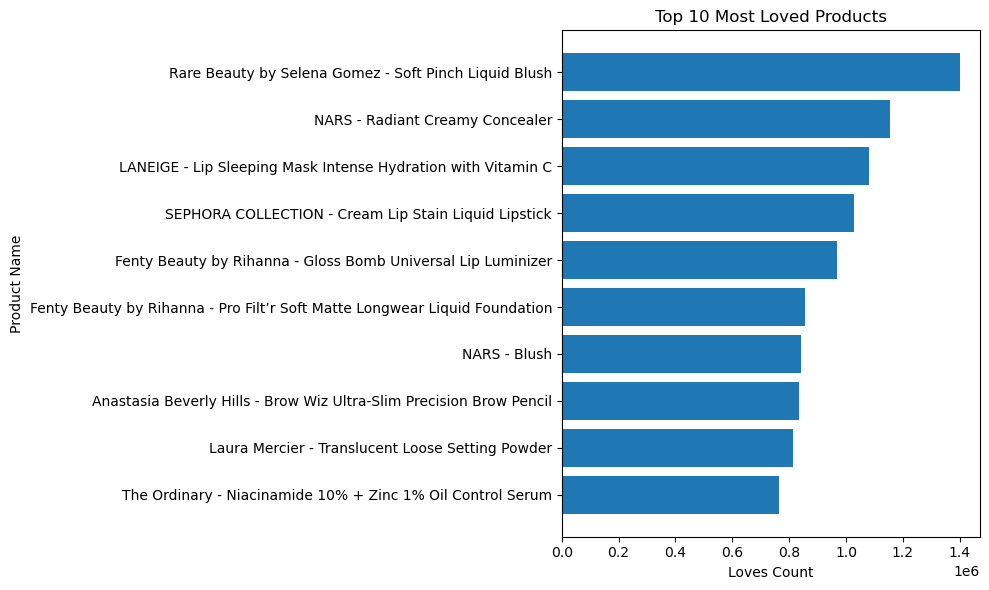

In [14]:

# Sort the products based on loves_count in descending order

df_product_info['product_brand'] = df_product_info['brand_name'] + ' - ' + df_product_info['product_name']
df_sorted = df_product_info.sort_values(by='loves_count', ascending=False)
top10_products = df_sorted.head(10)

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.barh(top10_products['product_brand'], top10_products['loves_count'])
plt.gca().invert_yaxis()
plt.ylabel('Product Name')
plt.xlabel('Loves Count')
plt.title('Top 10 Most Loved Products')
plt.yticks(rotation=0, ha='right')  # Rotate x-axis labels for better visibility
plt.tight_layout()

# Show the plot
plt.show()



# Trait Picker

###  Content-Based Filtering


Content-based filtering is a recommendation system technique where products are matched with a user's preferences based on the content features/attributues of the products that users have already interacted with. The technique analyzes product attributes such as description, features, category and other metadata. Recommendations are made by identifying products with content features similar to what the user has liked or engaged with before, enabling personalized suggestions without relying on other users' data or collaborative input.

### TF- IDF

The content-based filtering method was developed using the TF-IDF (Term Frequency-Inverse Document Frequency) algorithm to extract features from the product. The extracted features include ingredients,highlights, primary categories, and tertiary categories. 
After that, these features are combined into one representation vector using hstack. It aims to combine information from various product attributes into one comprehensive feature representation.

The TF-IDF model is an analysis method that evaluates how relevant a word in a document is in a collection of documents. TF-IDF is a combination of two extraction methods, namely TF (Term Frequency) and IDF (Inverse Document Frequency). 
TF calculates how often a word appears in a document and IDF calculates how common or rare a word is in the entire collection of documents, thus knowing the importance of a word.

In [15]:
def compute_similarity_matrix(df_product):
    """
    Compute a similarity matrix using TFIDF (Term Frequency-Inverse Document Frequency) model.

    Args:
    - df_product (pd.DataFrame): The input DataFrame containing product information.
        It is expected to have columns like 'ingredients', 'highlights', 'primary_category',
        'secondary_category', and 'tertiary_category'.

    Returns:
    - similarity_matrix (numpy.ndarray): A 2D array representing the cosine similarity matrix
        between the combined TFIDF feature vectors of 'ingredients', 'highlights',
        'primary_category', 'secondary_category', and 'tertiary_category' columns in df_product.
    """
    # Create a TFIDF vectorizer
    tfidf = TfidfVectorizer()

    # Compute TFIDF vectors for each textual column
    ingredient_vector = tfidf.fit_transform(df_product['ingredients'])
    highlights_vector = tfidf.fit_transform(df_product['highlights'])
    prim_category_vector = tfidf.fit_transform(df_product['primary_category'])
    sec_category_vector = tfidf.fit_transform(df_product['secondary_category'])
    tert_category_vector = tfidf.fit_transform(df_product['tertiary_category'])

    # Combine TFIDF vectors for 'ingredients', 'highlights', 'primary_category',
    # 'secondary_category', and 'tertiary_category'
    feature_vectors = hstack((ingredient_vector, highlights_vector, prim_category_vector,
                              sec_category_vector, tert_category_vector))

    # Compute the cosine similarity matrix between the combined feature vectors
    similarity_matrix = cosine_similarity(feature_vectors)
    return similarity_matrix


Cosine similarity is a method for measuring the level of similarity between two vectors. In the context of documents, cosine similarity is used to compare the similarity between two documents based on the vector representation of these documents. 

In [16]:
# Similarity Calculation
df_product = df_product.reset_index(drop=True)
similarity_matrix = compute_similarity_matrix(df_product)

# Create a DataFrame from the cosine similarity matrix
sim_df = pd.DataFrame(similarity_matrix, index=df_product['product_id'], columns=df_product['product_id'])

# Print the shape of the DataFrame
print('Shape:', sim_df.shape)

# sample of the cosine similarity DataFrame
sim_df.sample(5, axis=1).sample(10, axis=0)

Shape: (7545, 7545)


product_id,P472311,P454992,P379449,P308201,P503294
product_id,,,,,
P422574,0.038102,0.155238,0.311039,0.470466,0.011404
P503867,0.250739,0.002722,0.024324,0.053388,0.325831
P416589,0.254712,0.000601,0.006946,0.004684,0.269684
P476529,0.055723,0.008671,0.039726,0.013659,0.087559
P465790,0.004675,0.003461,0.008065,0.000000,0.004555
P503757,0.014416,0.011628,0.003003,0.008470,0.002280
P469174,0.058134,0.009212,0.028601,0.015642,0.081197
P403928,0.039827,0.030226,0.011939,0.022106,0.039798
P501997,0.041709,0.029175,0.128771,0.010949,0.459282


## Top Recommendations: Content-Based Filtering

In [17]:
def get_recommendations(product_id, top_n):
    """
    Get product recommendations based on similarity.

    Parameters:
    - product_id (str): The ID of the product for which recommendations are sought.
    - top_n (int): The number of top recommendations to retrieve.

    Returns:
    pandas.DataFrame: A DataFrame containing the top recommendations with additional information.
    """
    # Find the index of the given product_id in the DataFrame
    product_index = df_product[df_product['product_id'] == product_id].index[0]

    # Retrieve the similarity scores for the given product
    similarities = similarity_matrix[product_index]

    #  Find the indices of the most similar products (excluding the product itself)
    similar_indices = np.argsort(similarities)[::-1][1:top_n+1]

    #  Extract relevant information for the recommended products
    recommendations = df_product.loc[similar_indices, ['product_id', 'product_name', 'brand_name', 'primary_category', 'tertiary_category']]

    # Add a 'rank' column to the recommendations
    recommendations.insert(0, 'rank', range(1, top_n+1))

    # Step 6: Return the recommendations DataFrame
    return recommendations

In [18]:
# Example usage
product_id ='P420652'

# Print information about the product
info_product = df_product[df_product['product_id'] == product_id][['product_id','product_name', 'brand_name', 'primary_category','secondary_category' ,'tertiary_category']]

product_table = tabulate(info_product, headers='keys', tablefmt='psql',showindex=False )

# Get recommendations
top_n = 10  # Specify the number of recommendations
recommendations = get_recommendations(product_id, top_n=top_n)

# Print the recommendations
recommendations_table = tabulate(recommendations, headers='keys', tablefmt='psql', showindex=False)

# Display the result
print("Product Information:")
print(product_table)
print("\nTop-{} Recommendations:".format(top_n))
print(recommendations_table)

Product Information:
+--------------+----------------------------------------------------+--------------+--------------------+------------------------+------------------------+
| product_id   | product_name                                       | brand_name   | primary_category   | secondary_category     | tertiary_category      |
|--------------+----------------------------------------------------+--------------+--------------------+------------------------+------------------------|
| P420652      | Lip Sleeping Mask Intense Hydration with Vitamin C | LANEIGE      | Skincare           | Lip Balms & Treatments | Lip Balms & Treatments |
+--------------+----------------------------------------------------+--------------+--------------------+------------------------+------------------------+

Top-10 Recommendations:
+--------+--------------+------------------------------------------+--------------------+--------------------+------------------------+
|   rank | product_id   | product_name

# Reviews Data Exploration 

The reviews dataset contains the ratings and the comments given by users for the Sephora products. It has around 50000 reviews captured

In [19]:
# Load reviews data 
df_reviews = pd.read_csv('datasets/reviews.csv', header = 0, low_memory=False)

In [20]:
df_reviews.head()

,Unnamed: 0,author_id,rating,is_recommended,helpfulness,total_feedback_count,total_neg_feedback_count,total_pos_feedback_count,submission_time,review_text,review_title,skin_tone,eye_color,skin_type,hair_color,product_id,product_name,brand_name,price_usd
0,0,1945004256,5,1.0,0.000000,2,2,0,2022-12-10,I absolutely L-O-V-E this oil. I have acne pro...,A must have!,lightMedium,green,combination,NaN,P379064,Lotus Balancing & Hydrating Natural Face Treat...,Clarins,65.0
1,1,5478482359,3,1.0,0.333333,3,2,1,2021-12-17,I gave this 3 stars because it give me tiny li...,it keeps oily skin under control,mediumTan,brown,oily,black,P379064,Lotus Balancing & Hydrating Natural Face Treat...,Clarins,65.0
2,2,29002209922,5,1.0,1.000000,2,0,2,2021-06-07,Works well as soon as I wash my face and pat d...,Worth the money!,lightMedium,brown,dry,black,P379064,Lotus Balancing & Hydrating Natural Face Treat...,Clarins,65.0
3,3,7391078463,5,1.0,1.000000,2,0,2,2021-05-21,"this oil helped with hydration and breakouts, ...",best face oil,lightMedium,brown,combination,blonde,P379064,Lotus Balancing & Hydrating Natural Face Treat...,Clarins,65.0
4,4,1766313888,5,1.0,1.000000,13,0,13,2021-03-29,This is my first product review ever so that s...,Maskne miracle,mediumTan,brown,combination,black,P379064,Lotus Balancing & Hydrating Natural Face Treat...,Clarins,65.0


In [21]:
df_reviews.shape

(49977, 19)

In [22]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49977 entries, 0 to 49976
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                49977 non-null  int64  
 1   author_id                 49977 non-null  object 
 2   rating                    49977 non-null  int64  
 3   is_recommended            46160 non-null  float64
 4   helpfulness               36522 non-null  float64
 5   total_feedback_count      49977 non-null  int64  
 6   total_neg_feedback_count  49977 non-null  int64  
 7   total_pos_feedback_count  49977 non-null  int64  
 8   submission_time           49977 non-null  object 
 9   review_text               49918 non-null  object 
 10  review_title              35599 non-null  object 
 11  skin_tone                 42776 non-null  object 
 12  eye_color                 43717 non-null  object 
 13  skin_type                 46346 non-null  object 
 14  hair_c

In [23]:
# use relevant columns
df_review = df_reviews[['author_id', 'product_id', 'rating']]

In [24]:
(df_review.isnull() | df_review.empty | df_review.isna()).sum()

author_id     0
product_id    0
rating        0
dtype: int64

In [25]:
#remove duplicate reviews
df_review.duplicated().sum()
df_review = df_review.drop_duplicates()

# Review Stats

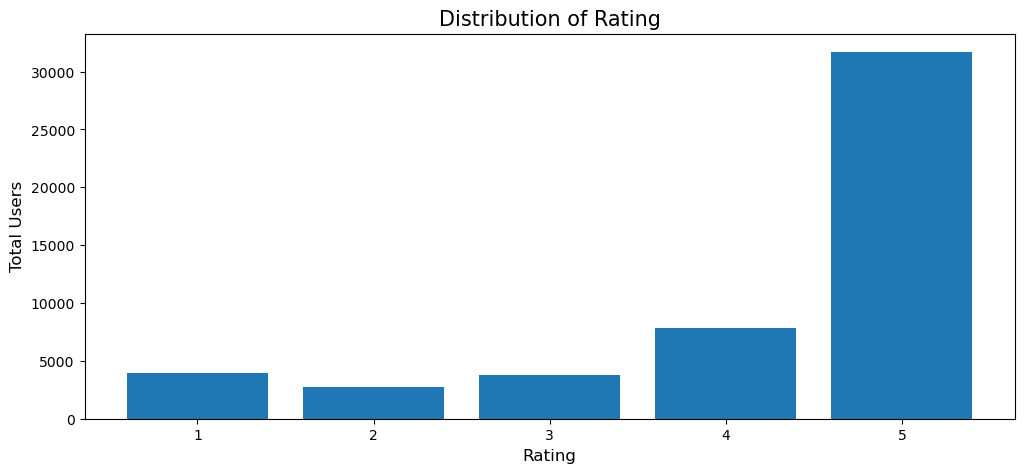

In [26]:
import matplotlib.pyplot as plt

# Create a single set of axes
fig, ax = plt.subplots(figsize=(12, 5))

# Count the occurrences of each rating
rating_counts = df_review['rating'].value_counts().sort_index()

# Plot bars for each rating
ax.bar(rating_counts.index, rating_counts )

ax.set_xlabel('Rating', fontsize=12)
ax.set_ylabel('Total Users', fontsize=12)
ax.set_title('Distribution of Rating', fontsize=15)

plt.show()


In [27]:
df_review.head()

,author_id,product_id,rating
0,1945004256,P379064,5
1,5478482359,P379064,3
2,29002209922,P379064,5
3,7391078463,P379064,5
4,1766313888,P379064,5



* The 'author_id' represents the user identifier or user's unique ID.
* The 'product_id' represents the item identifier.
* The 'rating' represents the rating given by the user to a specific product.

## Collaborative Filtering

Collaborative filtering is a recommendation technique that identifies patterns in users' behavior and preferences to make predictions about what users might like. It works by finding similarities between users or items based on their historical interactions, enabling the system to recommend items liked by similar users or items related to those a user has shown interest in. Collaborative filtering can be user-based (finding similar users) or item-based (finding similar items) and is widely used in recommendation systems to provide personalized suggestions.

Colaborative filtering is further classified into two types. Memory based CF and model based CF 

### Surprise Library 

Surprise (Simple Python RecommendatIon System Engine) is a Python scikit for building and analyzing recommender systems. It provides a simple and easy-to-use interface for various collaborative filtering algorithms and other recommendation techniques.

Surprise allows you to experiment with different recommendation algorithms, evaluate their performance, and make predictions using user-item interactions data.

To prepare data for the Surprise library, you need to create a dataset object using the Dataset class provided by Surprise. 

For a dataset with explicit ratings (e.g product ratings on a scale of 1 to 5), you can create a dataset using the Dataset.load_from_df() method. The pandas dataframe should contain the following columns user_id, item_id, and rating.

In [28]:
# Create a Surprise Dataset
reader = Reader(rating_scale=(0, 5))
review_data = Dataset.load_from_df(df_review, reader)

For evaluating thew models performance,  we further split the review data into train and test sets. 

In [29]:
# Split the data into training and testing sets
trainset, testset = train_test_split(review_data, test_size=.2, random_state=42)

### Model based Collaborative Filtering 

Model-based collaborative filtering methods, builds predictive models using machine learning algorithms to learn patterns and make recommendations. These methods create a model from the user-item interaction data, allowing for predictions even for unseen user-item pairs. There are several techniques used for model-based collaborative filtering. One such method is matrix factorization.



Matrix factorization is a technique used in recommendation systems where a large user-item interaction matrix is decomposed into two lower-dimensional matrices: one representing users and the other representing items. 
By learning latent features from these matrices using optimization algorithms like stochastic gradient descent, the model captures underlying patterns in the data. 
Matrix factorization helps fill in missing values in the original matrix and enables making recommendations for users on items they haven't interacted with, making it a key component in collaborative filtering-based recommendation systems.

Singular Value Decomposition (SVD) is a common matrix factorization technique used for collaborative filtering.

In [30]:
# Use SVD algorithm
model_svd = SVD()

Cross-validation is a technique used to assess the performance of a machine learning model by splitting the dataset into multiple subsets. 
The model is trained on several subsets and evaluated on the remaining data, ensuring robustness and preventing overfitting. It provides a more reliable estimate of the model's generalization ability compared to a single train-test split.

In [31]:
# Perform cross-validation on surprise_data (train-test)
cv_results = cross_validate(model_svd, review_data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

# Display the average RMSE and MAE scores of SVD
print("Cross-validation Results (SVD):")
print(f"RMSE: {cv_results['test_rmse'].mean()}")
print(f"MAE: {cv_results['test_mae'].mean()}")

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.1813  1.2054  1.2074  1.1804  1.1906  1.1930  0.0115  
MAE (testset)     0.9021  0.9193  0.9211  0.8995  0.9113  0.9107  0.0087  
Fit time          0.25    0.24    0.23    0.25    0.27    0.25    0.01    
Test time         0.02    0.02    0.07    0.02    0.02    0.03    0.02    
Cross-validation Results (SVD):
RMSE: 1.1930363268917035
MAE: 0.9106594281071277


In [32]:
# Train the model on the whole train dataset
trainset = review_data.build_full_trainset()
model_svd.fit(trainset)

In [33]:
# Make predictions for the test set
predictions = model_svd.test(testset)

# Convert Surprise Prediction objects to a format suitable for sklearn evaluation metrics
true_labels = np.array([pred.r_ui for pred in predictions])
predicted_labels = np.array([pred.est for pred in predictions])

# Binarize the true labels and predicted labels (e.g., using a threshold)
threshold = 3
binarized_true_labels = (true_labels >= threshold).astype(int)
binarized_predicted_labels = (predicted_labels >= threshold).astype(int)

# Compute precision, recall, and F1-score
precision = precision_score(binarized_true_labels, binarized_predicted_labels)
recall = recall_score(binarized_true_labels, binarized_predicted_labels)
f1 = f1_score(binarized_true_labels, binarized_predicted_labels)

# Compute RMSE and MAE
rmse_score = rmse(predictions)
mae_score = mae(predictions)

# Display the evaluation metrics
print("Evaluation Metrics of SVD:")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")
print(f"RMSE: {rmse_score}")
print(f"MAE: {mae_score}")

RMSE: 0.7985
MAE:  0.6073
Evaluation Metrics of SVD:
Precision: 0.9184431010711634
Recall: 0.9983859810929214
F1-score: 0.956747500414296
RMSE: 0.7985208127954319
MAE: 0.6073121734507573


### Hyperparameter Tuning

Hyperparameter tuning involves finding the best configuration of settings for a machine learning algorithm. These settings, called hyperparameters, are not learned from the data but are set before training. 
Methods like grid search or random search systematically explore different combinations to optimize these hyperparameters and enhance the model's performance on unseen data.

In [34]:
# Define the parameter grid for hyperparameter tuning
param_grid = {'n_factors': [50, 100],
              'n_epochs': [20, 30, 50],     # Number of epochs
              'lr_all': [0.005, 0.01, 0.001, 0.002], # Learning rate for all parameters
              'reg_all': [0.05, 0.1, 0.01, 0.2]}   # Regularization term for all parameters

# Use GridSearchCV to find the best hyperparameters
model_svd_tune = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=5, n_jobs=-1)
model_svd_tune.fit(review_data)

In [35]:
# Get the best hyperparameters and the corresponding RMSE and MAE scores
best_rmse = model_svd_tune.best_score['rmse']
best_mae = model_svd_tune.best_score['mae']
best_params = model_svd_tune.best_params['rmse']

print(f"Best RMSE: {best_rmse}")
print(f"Best MAE: {best_mae}")
print(f"Best Parameters: {best_params}")

Best RMSE: 1.18114904388749
Best MAE: 0.8904291859951418
Best Parameters: {'n_factors': 50, 'n_epochs': 50, 'lr_all': 0.01, 'reg_all': 0.1}


In [36]:
# Train the model on the whole training set with the best parameters
svd_best_model = SVD(**best_params)
svd_best_model.fit(review_data.build_full_trainset())

In [37]:
# Make predictions for the test set
predictions = svd_best_model.test(testset)

# Convert Surprise Prediction objects to a format suitable for sklearn evaluation metrics
true_labels = np.array([pred.r_ui for pred in predictions])
predicted_labels = np.array([pred.est for pred in predictions])

# Binarize the true labels and predicted labels (e.g., using a threshold)
threshold = 3
binarized_true_labels = (true_labels >= threshold).astype(int)
binarized_predicted_labels = (predicted_labels >= threshold).astype(int)

# Compute precision, recall, and F1-score
precision = precision_score(binarized_true_labels, binarized_predicted_labels)
recall = recall_score(binarized_true_labels, binarized_predicted_labels)
f1 = f1_score(binarized_true_labels, binarized_predicted_labels)

# Compute RMSE and MAE
rmse_score = rmse(predictions)
mae_score = mae(predictions)

# Display the evaluation metrics
print("Evaluation Metrics of SVD:")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")
print(f"RMSE: {rmse_score}")
print(f"MAE: {mae_score}")

RMSE: 0.3388
MAE:  0.2550
Evaluation Metrics of SVD:
Precision: 0.9948234211434488
Recall: 0.9970025363154255
F1-score: 0.9959117867219439
RMSE: 0.3388493775809884
MAE: 0.2549545325703159


### Top recommendations for a user

In [38]:
# The method get_rated_products_by_user(user_id, df_review, df_product_info) takes the input user_id, review info and produict info and returns the list of products which the user had already interacted with. 

def get_rated_products_by_user(user_id, df_review, df_product_info):
    sample_user_ratings = df_review[(df_review['author_id'] == user_id) & (df_review['rating'] >= 4.0)]
    sample_user_products = df_product_info[df_product_info['product_id'].isin(sample_user_ratings['product_id'])]

    print("\nProducts with High Ratings by User", user_id, ":")

    # Create a list to store the product details
    product_details = []

    # Populate the product_details list
    for idx, product in sample_user_products.iterrows():
        product_id = product['product_id']
        product_name = product['product_name']
        primary_category = product['primary_category']
        rating = sample_user_ratings[sample_user_ratings['product_id'] == product_id]['rating'].values[0]
        product_details.append([product_id, product_name, primary_category, rating])
    return product_details 

In [39]:
user_id = '8447021668' #sample user id 
product_details = get_rated_products_by_user(user_id, df_review, df_product_info)
headers = ["Product ID", "Product Name", "Primary Category", "Rating"]
print(tabulate(product_details, headers=headers, tablefmt="psql"))


Products with High Ratings by User 8447021668 :
+--------------+------------------------------------------------------+--------------------+----------+
| Product ID   | Product Name                                         | Primary Category   |   Rating |
|--------------+------------------------------------------------------+--------------------+----------|
| P476681      | Hyaluronic Acid Roller Dissolving Microneedling Tool | Skincare           |        5 |
| P502322      | The Healthy Skin Edit Bestsellers Kit                | Skincare           |        5 |
| P504892      | Refine AHA + BHA Texture & Pore Serum                | Skincare           |        5 |
| P483701      | Daily Essentials Travel Set                          | Skincare           |        5 |
+--------------+------------------------------------------------------+--------------------+----------+


In [40]:
# The method get_user_recommendations(user_id, model, df_review, df_product_info) takes the input user_id, model type review info and produict info and returns the list of products which can be a potential recommendations for the user. 

def get_user_recommendations(user_id, model, df_review, df_product_info, n=10):
    # Get a list of all unique product IDs
    all_product_ids = df_review['product_id'].unique()

    # Remove products that the user has already rated
    products_rated_by_user = df_review[df_review['author_id'] == user_id]['product_id'].values
    products_to_predict = np.setdiff1d(all_product_ids, products_rated_by_user)

    # Make predictions for the products to predict
    predictions = [model.predict(user_id, product_id) for product_id in products_to_predict]

    # Sort the predictions by estimated ratings (in descending order)
    predictions.sort(key=lambda x: x.est, reverse=True)

    # Get the top-N recommended products
    top_n_recommendations = [prediction.iid for prediction in predictions[:n]]

    # Populate the recommendations list
    recommendations = []
    for i, product_id in enumerate(top_n_recommendations, start=1):
        # Find the product details in df_product_info
        product_details = df_product_info[df_product_info['product_id'] == product_id]

        if len(product_details) > 0:
            product_name = product_details['product_name'].values[0]
            primary_category = product_details['primary_category'].values[0]

            # Append the recommendation to the list
            recommendations.append([i, product_id, product_name, primary_category])

    return recommendations

In [41]:
user_id = '8447021668' #sample user id 
n= 10
recommendations = get_user_recommendations(user_id, svd_best_model , df_review, df_product_info, n)
headers = ["Rank", "Product ID", "Product Name", "Primary Category"]
print(f"\nTop-{n} Recommendations for User {user_id}:")
print(tabulate(recommendations, headers=headers, tablefmt="psql"))


Top-10 Recommendations for User 8447021668:
+--------+--------------+------------------------------------------------------------------+--------------------+
|   Rank | Product ID   | Product Name                                                     | Primary Category   |
|--------+--------------+------------------------------------------------------------------+--------------------|
|      1 | P409227      | Multi-Active Anti-Aging Day Moisturizer for Glowing Skin         | Skincare           |
|      2 | P419466      | Tan Build Up Remover Mitt                                        | Skincare           |
|      3 | P423163      | Future Solution LX Concentrated Balancing Softener               | Skincare           |
|      4 | P435790      | Radiance Revitalizing Foam                                       | Skincare           |
|      5 | P442546      | Balancing Cleanser                                               | Skincare           |
|      6 | P444470      | De-Puffing Rose Q

### Memory based Colaborative Filtering

Memory-based collaborative filtering methods make recommendations based on similarities between users or items, using the entire user-item interaction matrix. There are two main types of memory-based collaborative filtering:

User-Based Collaborative Filtering: It finds similar users to the target user based on their historical interactions and recommends items liked by those similar users. This method relies on the idea that users who have agreed in the past tend to agree again in the future.

Item-Based Collaborative Filtering: It identifies similar items to the ones a user has interacted with or liked. It recommends items related to those the user has shown interest in, leveraging the similarity between items based on user interactions.

Memory-based methods are simple to implement and easy to understand. They don't require training a model, as recommendations are generated directly from the existing user-item interactions. However, they might not perform well in cases of sparse data and suffer from the scalability issue, especially when dealing with a large number of users and items.

### K- Nearest Neighbors

k-NN (k-Nearest Neighbors) is a supervised machine learning algorithm used for classification and regression tasks. In k-NN, the prediction for a new data point is determined by the majority class (for classification) or the average of nearest k neighbors' values (for regression) in the training dataset. The choice of "k" specifies the number of neighboring data points considered, and the algorithm relies on the similarity measure (such as Euclidean distance) to identify the nearest neighbors.

Memory-Based Collaborative Filtering using k-NN (k-Nearest Neighbors) works by finding the most similar users or items to a target user or item based on their past interactions. 
For example, in User-Based CF, it identifies k nearest users to the target user and suggests items they liked. 
The similarity between users or items is calculated using metrics like cosine similarity, Pearson correlation, or others, and k represents the number of nearest neighbors considered for making recommendations.

### User- Based Collaborative Filtering


User-Based Collaborative Filtering: It finds similar users to the target user based on their historical interactions and recommends items liked by those similar users. 
This method relies on the idea that users who have agreed in the past tend to agree again in the future.

In [42]:

# Create a user-based k-NN model
model_user_knn = KNNBasic(sim_options={'user_based': True})

# Train the model on the training set
model_user_knn.fit(trainset)

# Make predictions for the test set
predictions_user_knn = model_user_knn.test(testset)

# Calculate RMSE to evaluate the model's accuracy
rmse_user_knn = accuracy.rmse(predictions_user_knn)
print("RMSE (User-Based k-NN):", rmse_user_knn)

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.3725
RMSE (User-Based k-NN): 0.37247487655473654


### Hyper parameter Tuning using Grid search CV for optimal K

In [43]:


param_grid = {'k': [5, 10, 15, 20]}
grid_search = GridSearchCV(KNNBasic, param_grid, measures=['rmse'], cv=5)
grid_search.fit(review_data)

# Get the best k value from the grid search
best_k = grid_search.best_params['rmse']['k']
print("Best k:", best_k)

best_params = grid_search.best_params['rmse']
best_params = grid_search.best_params


print(f"Best RMSE: {best_rmse}")
print(f"Best Parameters: {best_params}")

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computi

In [44]:
# Retrianing the model with best params from Gridsearch
knn_best_model = KNNBasic(**best_params)
knn_best_model.fit(review_data.build_full_trainset())

Computing the msd similarity matrix...
Done computing similarity matrix.


### Top recommendations for a user using KNN Model 

In [45]:
user_id = '8447021668' #sample user id 
product_details = get_rated_products_by_user(user_id, df_review, df_product_info)
headers = ["Product ID", "Product Name", "Primary Category", "Rating"]
print(tabulate(product_details, headers=headers, tablefmt="psql"))


Products with High Ratings by User 8447021668 :
+--------------+------------------------------------------------------+--------------------+----------+
| Product ID   | Product Name                                         | Primary Category   |   Rating |
|--------------+------------------------------------------------------+--------------------+----------|
| P476681      | Hyaluronic Acid Roller Dissolving Microneedling Tool | Skincare           |        5 |
| P502322      | The Healthy Skin Edit Bestsellers Kit                | Skincare           |        5 |
| P504892      | Refine AHA + BHA Texture & Pore Serum                | Skincare           |        5 |
| P483701      | Daily Essentials Travel Set                          | Skincare           |        5 |
+--------------+------------------------------------------------------+--------------------+----------+


In [46]:
user_id = '8447021668' #sample user id 
n= 10
recommendations = get_user_recommendations(user_id, knn_best_model , df_review, df_product_info, n)
headers = ["Rank", "Product ID", "Product Name", "Primary Category"]
print(f"\nTop-{n} Recommendations for User {user_id}:")
print(tabulate(recommendations, headers=headers, tablefmt="psql"))


Top-10 Recommendations for User 8447021668:
+--------+--------------+--------------------------------------------------------+--------------------+
|   Rank | Product ID   | Product Name                                           | Primary Category   |
|--------+--------------+--------------------------------------------------------+--------------------|
|      1 | P379064      | Lotus Balancing & Hydrating Natural Face Treatment Oil | Skincare           |
|      2 | P398500      | Personal Microderm                                     | Skincare           |
|      3 | P401158      | PMD Personal Microderm with Hand & Foot Kit            | Skincare           |
|      4 | P423157      | Sex Dust   Adaptogens For Fire*                        | Skincare           |
|      5 | P430809      | THE ESSENTIALS Sonic Dermaplaning Refill Kit           | Skincare           |
|      6 | P432835      | Rose Quartz Facial De-Puffing & Lifting Gua Sha        | Skincare           |
|      7 | P433468 

### KNN with Z score 

KNNWithZScore is an enhancement of the basic k-NN algorithm that performs mean centering before computing similarities. Mean centering involves subtracting the mean rating of each user (user-based) or each item (item-based) from the raw ratings. This normalization helps handle users/items with different rating scales, making the similarity computation more robust.

In [47]:
from surprise.model_selection import GridSearchCV

param_grid = {'k': [5, 10, 15, 20]}
grid_search = GridSearchCV(KNNWithZScore, param_grid, measures=['rmse'], cv=5)
grid_search.fit(review_data)

# Get the best k value from the grid search
best_k = grid_search.best_params['rmse']['k']
print("Best k:", best_k)

best_params = grid_search.best_params['rmse']
best_params = grid_search.best_params

print(f"Best RMSE: {best_rmse}")
print(f"Best Parameters: {best_params}")

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computi

In [48]:

from surprise import KNNBasic, KNNWithZScore
knn_zscore_best_model = KNNWithZScore(**best_params)
knn_zscore_best_model.fit(review_data.build_full_trainset())

Computing the msd similarity matrix...
Done computing similarity matrix.


### Top Recommendations for a user using KNN- Zscore Model 

In [49]:
user_id = '8447021668' #sample user id 
product_details = get_rated_products_by_user(user_id, df_review, df_product_info)
headers = ["Product ID", "Product Name", "Primary Category", "Rating"]
print(tabulate(product_details, headers=headers, tablefmt="psql"))


Products with High Ratings by User 8447021668 :
+--------------+------------------------------------------------------+--------------------+----------+
| Product ID   | Product Name                                         | Primary Category   |   Rating |
|--------------+------------------------------------------------------+--------------------+----------|
| P476681      | Hyaluronic Acid Roller Dissolving Microneedling Tool | Skincare           |        5 |
| P502322      | The Healthy Skin Edit Bestsellers Kit                | Skincare           |        5 |
| P504892      | Refine AHA + BHA Texture & Pore Serum                | Skincare           |        5 |
| P483701      | Daily Essentials Travel Set                          | Skincare           |        5 |
+--------------+------------------------------------------------------+--------------------+----------+


In [50]:
user_id = '8447021668' #sample user id 
n= 10
recommendations = get_user_recommendations(user_id, knn_zscore_best_model, df_review, df_product_info, n)
headers = ["Rank", "Product ID", "Product Name", "Primary Category"]
print(f"\nTop-{n} Recommendations for User {user_id}:")
print(tabulate(recommendations, headers=headers, tablefmt="psql"))


Top-10 Recommendations for User 8447021668:
+--------+--------------+------------------------------------------------------------+--------------------+
|   Rank | Product ID   | Product Name                                               | Primary Category   |
|--------+--------------+------------------------------------------------------------+--------------------|
|      1 | P173622      | Benefiance Pure Retinol Intensive Revitalizing Face Mask   | Skincare           |
|      2 | P202935      | Benefiance NutriPerfect Night Cream                        | Skincare           |
|      3 | P2046        | Brumisateur Natural Mineral Water Facial Spray Travel Trio | Skincare           |
|      4 | P232920      | Line Release Under Eye Repair Cream                        | Skincare           |
|      5 | P270600      | Extra Eye Repair Cream Intense                             | Skincare           |
|      6 | P309409      | Repairwear Uplifting Firming Cream                         | Skin

# Item based Collaborative Filterting 

Item-Based Collaborative Filtering: It identifies similar items to the ones a user has interacted with or liked. It recommends items related to those the user has shown interest in, leveraging the similarity between items based on user interactions.

In [51]:
model_item_knn = KNNBasic(sim_options={'user_based': False})

# Train the model on the training set
model_item_knn.fit(trainset)

# Make predictions for the test set
predictions_item_knn = model_item_knn.test(testset)

# Calculate RMSE to evaluate the model's accuracy
rmse_item_knn = accuracy.rmse(predictions_item_knn)
print("RMSE (Item-Based k-NN):", rmse_item_knn)

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.1586
RMSE (Item-Based k-NN): 0.15863751755188985


In [52]:
user_id = '8447021668' #sample user id 
product_details = get_rated_products_by_user(user_id, df_review, df_product_info)
headers = ["Product ID", "Product Name", "Primary Category", "Rating"]
print(tabulate(product_details, headers=headers, tablefmt="psql"))


Products with High Ratings by User 8447021668 :
+--------------+------------------------------------------------------+--------------------+----------+
| Product ID   | Product Name                                         | Primary Category   |   Rating |
|--------------+------------------------------------------------------+--------------------+----------|
| P476681      | Hyaluronic Acid Roller Dissolving Microneedling Tool | Skincare           |        5 |
| P502322      | The Healthy Skin Edit Bestsellers Kit                | Skincare           |        5 |
| P504892      | Refine AHA + BHA Texture & Pore Serum                | Skincare           |        5 |
| P483701      | Daily Essentials Travel Set                          | Skincare           |        5 |
+--------------+------------------------------------------------------+--------------------+----------+


In [53]:
user_id = '8447021668' #sample user id 
n= 10
recommendations = get_user_recommendations(user_id, model_item_knn, df_review, df_product_info, n)
headers = ["Rank", "Product ID", "Product Name", "Primary Category"]
print(f"\nTop-{n} Recommendations for User {user_id}:")
print(tabulate(recommendations, headers=headers, tablefmt="psql"))


Top-10 Recommendations for User 8447021668:
+--------+--------------+------------------------------------------------------------------------+--------------------+
|   Rank | Product ID   | Product Name                                                           | Primary Category   |
|--------+--------------+------------------------------------------------------------------------+--------------------|
|      1 | P302900      | Turnaround Revitalizing Serum                                          | Skincare           |
|      2 | P379064      | Lotus Balancing & Hydrating Natural Face Treatment Oil                 | Skincare           |
|      3 | P386755      | Collagen Love Skin Firming Supplement with Hyaluronic Acid & Vitamin C | Skincare           |
|      4 | P398500      | Personal Microderm                                                     | Skincare           |
|      5 | P398502      | Personal Microderm Pro                                                 | Skincare        